In [1]:
import numpy as np;
import matplotlib.pyplot as plt;

In [2]:
def f2(x):
    return 1 + x*np.log(x)**2;

In [3]:
def runUCB():
    global eta, seq;
    global N, K, c, d;
    global Phi, theta;
    global R_max;
    
    tau = np.zeros( (K, c+d) );
    s = np.zeros( (K, c+d) );
    Reg = np.zeros(N);
    Reg_exp = np.zeros(N);
    
    for t in range(N):
        i = seq[t];

        a_t = 0;        
        ucb = 0;
        for a in range(K):
            if tau[a][i] > 0:
                m_a = s[a][i] / tau[a][i];
                v_a = 2 * np.log(f2(t+1)) / tau[a][i];
                ucb_a = m_a + np.sqrt(v_a);
                if a == 0 or ucb < ucb_a:
                    ucb = ucb_a;
                    a_t = a;
            else:
                a_t = a;
                break;
                
        if t > 0:
            Reg[t] = Reg[t-1];
            Reg_exp[t] = Reg_exp[t-1];
        
        tau[a_t][i] = tau[a_t][i] + 1;
        X_t = Phi[a_t][i].dot( theta[a_t] ) + eta[t];
        s[a_t][i] = s[a_t][i] + X_t; 
        Reg[t] = Reg[t] + R_max[i] - X_t;
        Reg_exp[t] = Reg_exp[t] + R_max[i] - Phi[a_t][i].dot( theta[a_t] );
    
    return np.array([Reg, Reg_exp]);

In [4]:
def runlinUCBg():
    global eta, seq;
    global N, K, c, d;
    global S, L;
    global Phi, theta;
    global R_max;
    
    A = [np.identity(d)]*K;
    tau = np.zeros(K);
    b = np.zeros((K, d));
    
    Reg = np.zeros(N);
    Reg_exp = np.zeros(N);
    
    for t in range(N):
        i = seq[t];

        a_t = 0;               
        ucb = 0;
        
        alpha = 0; # Greedy sets alpha = 0, #L*S + np.sqrt((2+d)*np.log(f2(t+1)));

        for a in range(K):
            beta_a = np.linalg.solve( A[a], b[a] );
            m_a = beta_a.dot(Phi[a][i]);
            v_a = Phi[a][i].dot(np.linalg.solve(A[a], Phi[a][i]));
            ucb_a = m_a + alpha * np.sqrt(v_a);
            if a == 0 or ucb_a > ucb:
                ucb = ucb_a;
                a_t = a;
                
        if t > 0:
            Reg[t] = Reg[t-1];
            Reg_exp[t] = Reg_exp[t-1];
        
        tau[a_t] = tau[a_t] + 1;
        X_t = Phi[a_t][i].dot( theta[a_t] ) + eta[t];
        
        A[a_t] = A[a_t] + np.transpose([Phi[a_t][i]]).dot( [Phi[a_t][i]] );
        b[a_t] = b[a_t] + X_t*Phi[a_t][i];
        
        Reg[t] = Reg[t] + R_max[i] - X_t;
        Reg_exp[t] = Reg_exp[t] + R_max[i] - Phi[a_t][i].dot( theta[a_t] );
    
    return np.array([Reg, Reg_exp]);

In [5]:
def runlinUCBd():
    global eta, seq;
    global N, K, c, d;
    global S, L;
    global Phi, Phi_ext, theta;
    global R_max;
    
    #tau = np.concatenate( [np.ones((K,d)), np.zeros((K,c))], axis=1);
    #s = np.zeros( (K, c+d) );
    Reg = np.zeros(N);
    Reg_exp = np.zeros(N);
    
    A = [np.identity(d) * L]*K;
    b = np.zeros((K, d));
    
    for t in range(N):
        i = seq[t];

        a_t = 0;
        ucb = 0;
        alpha = L*S + np.sqrt((2+d)*np.log(f2(t+1)));

        for a in range(K):
            #T = np.diag(tau[a]);
            #D = np.transpose(Phi_ext[a]).dot(T).dot(Phi_ext[a]);
            D = A[a];   
            # A[a] is equivalent to using T to calculate D
            
            l = np.linalg.solve( D, Phi_ext[a][i+d] );
            
            #m_a = s[a].dot(Phi_ext[a]).dot(l);
            m_a = b[a].dot(l);   
            # b[a] is equivalent to s[a].dot(Phi_ext[a])
            
            v_a = l.dot(Phi_ext[a][i+d]);
            ucb_a = m_a + alpha * np.sqrt(v_a);
            if a == 0 or ucb < ucb_a:
                ucb = ucb_a;
                a_t = a;
                
        if t > 0:
            Reg[t] = Reg[t-1];
            Reg_exp[t] = Reg_exp[t-1];
        
                
        X_t = Phi[a_t][i].dot( theta[a_t] ) + eta[t];
        
        #tau[a_t][i+d] = tau[a_t][i+d] + 1;
        #s[a_t][i+d] = s[a_t][i+d] + X_t; 
        A[a_t] = A[a_t] + np.transpose([Phi[a_t][i]]).dot( [Phi[a_t][i]] );
        b[a_t] = b[a_t] + X_t*Phi[a_t][i];
        # equivalent to update T, D and b
        
        Reg[t] = Reg[t] + R_max[i] - X_t;
        Reg_exp[t] = Reg_exp[t] + R_max[i] - Phi[a_t][i].dot( theta[a_t] );
    
    return np.array([Reg, Reg_exp]);

In [6]:
def genRand():
    global eta, seq, d;
    eta = np.random.normal(0, 1, N);
    #eta = [0]*N;
    seq = np.array( range(N) );
    
    global K, c, R, R_max, Phi, Phi_ext
    R.fill(0);
    R_max.fill(0);
    Phi.fill(0);
    Phi_ext.fill(0);

    # Generate Contexts with Reward Gap >= delta
    for i in range(c):
        R_2ndmax = 0;
        while (R_max[i] < R_2ndmax + delta):
            for a in range(K):
                Phi[a][i] = np.random.rand( d );
                Phi_norm = np.sqrt( Phi[a][i].dot( Phi[a][i] ) );
                Phi[a][i] = Phi[a][i] * L / Phi_norm;
                R[a][i] = Phi[a][i].dot( theta[a] );
            R_2ndmax, R_max[i] = np.sort(R[:,i])[-2:];
    
    Phi_ext = np.array( [[[0.]*d ]*(c+d)] * K);
    for i in range(K):
        Phi_ext[i] = np.concatenate([np.identity(d)*L, Phi[i]]);
    
def run():
    global N, M;
    global Reg_UCB, Reg_linUCBg, Reg_linUCBd;
    global Sigma_UCB, Sigma_linUCBg, Sigma_linUCBd;
    
    #Reg_UCB = np.zeros((2,N));
    Reg_linUCBg = np.zeros((2,N));
    Reg_linUCBd = np.zeros((2,N));

    #Sigma_UCB = np.zeros((2,N));
    Sigma_linUCBg = np.zeros((2,N));
    Sigma_linUCBd = np.zeros((2,N));
    
    for m in range(M):
        genRand();
        #Reg_UCB = Reg_UCB + runUCB();
        #Reg_linUCB = Reg_linUCB + runlinUCB();
        Reg = runlinUCBg();
        Reg_linUCBg = Reg_linUCBg + Reg;
        Sigma_linUCBg = Sigma_linUCBg + Reg*Reg;
        
        Reg = runlinUCBd();
        Reg_linUCBd = Reg_linUCBd + Reg;
        Sigma_linUCBd = Sigma_linUCBd + Reg*Reg; 
    
    #Reg_UCB = Reg_UCB / M;
    #Reg_linUCB = Reg_linUCB / M;
    Reg_linUCBg = Reg_linUCBg / M;
    Sigma_linUCBg = np.sqrt( Sigma_linUCBg / M - Reg_linUCBg * Reg_linUCBg);
    
    Reg_linUCBd = Reg_linUCBd / M;
    Sigma_linUCBd = np.sqrt( Sigma_linUCBd / M - Reg_linUCBd * Reg_linUCBd);

In [7]:
# save random seed
state0 = ('MT19937', np.array([ 982403191, 1858768038,  404494468, 4019715445,  191118029,
        758017443, 1155932939, 1189092168, 1499599753, 2246756259,
       2015775420, 3232511692,  597651385, 2066062761, 3252085231,
       2746565541,  874018529, 2141171205, 2426906489, 2013182382,
       2670069991, 4186145205, 1261600516, 3547866392, 2831341473,
       4102728244,  927156016, 2996219018, 2457731554, 1211646284,
        835085239, 1702012201,  270555827, 3187822456, 4249509270,
       3294048548, 2686079344, 3686039402, 1511411900,   34014738,
       1952580117, 2827827794, 4026856020, 1116174795, 1896621853,
       3753028086, 3849464923, 1115854935, 3606765345,  354122752,
       4259795605, 2216683825, 3886287488, 3224487246, 1250384267,
       2878892975, 1287080200, 1511547708, 2935143383, 1741199494,
       2034416524, 1613034846, 2331813012, 2798348326, 2669469521,
       2972426296, 2438224998, 3829865560, 2430766247,  686921751,
       2070442649, 3143066491, 1885010029, 4124891060, 3064249912,
       1447134885, 1906510650, 2770085442, 2264535302, 1964503031,
        749087407,  468042262, 1990394469, 1348304689,  785412423,
       2281119917, 1472267167, 3939336689, 4271341209, 3467227469,
       1710458650, 2394903671, 2175648104, 3760712828, 3519425530,
       3310575448, 3735078971,  266608814, 3071007680, 1211591045,
        149411467, 3363386435, 4110466887, 3930717612,  431500145,
       2774658389, 3723538554, 3564333569,  372594157, 2359149331,
       1132235112, 1116192579, 3375141092, 2679397276,  116979182,
       2885502793, 3817565038, 3815390209,  933073763, 1000399497,
       2941349611,  718592389, 3283674088, 3410332677, 1302996465,
       1756088467, 1459105703, 1252630666,  544344915, 1514747278,
        653420666, 4128829254, 3727665317, 1355970208, 3034519422,
       1465203726, 1165234182, 2548663442, 1123321492,  575740778,
        543953434, 2839648298, 1768065681, 4184760896, 1227541538,
       1309829752,  205508607, 2413340716,  126197074, 2921954436,
        327748883,   59260067, 3342418900, 1416371387, 3786214705,
        898825653, 1681886348, 4070804649,    9689712, 1851586650,
       3708538397, 3920117024,  646886731, 3560325799, 1329120839,
       3773770706, 3547926697, 1113053752, 3743009479,    9341401,
       3242047311, 2410479656, 3351605792, 2194579774, 3476799785,
       1583936762, 3000501150, 3627384998, 2345080669,  477548998,
         85990405, 1860717988,  820103932,  152673488,  767384801,
       3054141676, 2904086563, 3377654290, 3120335127, 2097282746,
       2451537098,  305034364, 3841747781, 3847308924, 2421784790,
       3337223492, 2300994972, 2040148644, 4275205723,  775626779,
       1391552092, 1097721427, 1078526962, 3746929499, 3283098538,
       3855617680,  400088813, 1097646700, 2023009168, 3698870824,
        961721148, 2390877335, 1369386742, 3957941964, 2823702589,
       3811156051, 2908102655, 2118393805,  360374474, 2732268232,
       2444800987, 2013354202,  414963431, 2069715453, 3485758044,
       2535814914, 2332288542,  594919120, 3508154328, 2492847965,
       3506723431, 1866572709, 1057970812, 1668944430, 2503227516,
        815004627,  412921344, 1853243900,  293113393, 2922207383,
       1335862428,  403107543, 1107358743, 3219155697, 1797827525,
        315296308, 2244209081, 1975764326,  958238570, 2237044296,
       3927645246, 1656717564,  512006052, 2555509201, 4188693504,
        946690662,  362385984, 3965386116, 3307541463,  946370724,
       1053484042,  546887980, 2372362931, 2784991619,   47750457,
       2653965281, 2854533295,   74635855,  902713604, 2144198802,
       1195381586, 2960849714, 1825174812, 2682497077, 2650640906,
       1131453318,  508420318, 2534098514, 1433393926, 3181162494,
       2754878282, 2682686134, 1338919615,  667889821, 3129140877,
       2718787101, 2826334404,  567652165, 4243993372, 2256259267,
       1281827284, 2235503734, 4171063885, 2804962945, 4189805234,
       2820221291, 2792000523, 2189225938, 3032640931, 1252450547,
       2123258228, 1025321552, 1453520405, 1969951562, 4165321147,
        892846109, 2393564699,  122548795,  961358981,  624937994,
        230041868, 3295762483, 1830268838, 1951313154, 2601210372,
       2562951881,  682659418, 1468367230,  465901332, 3743000983,
       2718153013, 3135443415,  324955660, 3764713369, 1899330912,
       3439260334, 1144716343, 3651895824, 2830361076, 1793310536,
       4180407145,  772114599, 1096228143, 3574401760,  896614455,
        916054200, 2866756052, 2240514050,  280958062, 4132229162,
       3444758973, 2894616688,  503432074,  816462756, 3611045211,
       3749693186, 2111976975, 2731293214, 3240914975, 2387794324,
       3516730394, 3150238433,  841007936, 3071515664, 1702344864,
       3217679596, 2619357263, 3838373626, 3679422774,  645257191,
       2108230285, 1757704177, 2977738588, 2332806120, 2324428978,
       1265160732,  741266353, 2423460473,  928761156, 2472916347,
       2381295659, 2389338752,   41267389, 4238458147, 1902363972,
       1224587461, 1419016059, 3288565991, 3382978880, 3920219278,
       2234600382, 3591339773, 3037517067, 1611353618, 2957874093,
        450592158,  198972253, 3927649646, 3697079700, 2694807453,
       2828083899,  969186556,  423802946, 4210292938, 2062795557,
       1065012350, 1147212989, 1251655787, 4037570736, 1855757263,
       2435589749, 4001575915, 3872089007,  512702705, 2110751488,
       4123557242, 3259443331, 3482406264, 1770970237,  996593951,
       3118758883,  410173468, 2873576010, 4220076148,  512657048,
       4228947044, 3165697692, 4153064476, 1418413029, 1593481523,
        604030040, 2421673453,   71948465,   89770237,  211796509,
       2467874165, 1550351664, 1013642338, 3833581879, 1970013889,
        736782542, 2014113653,  777944142, 1060953341, 3991672752,
       2769308828, 3333600309, 1020842218, 2663675859, 3008546800,
       1935437585, 3039663039,  473802506, 2887942043,  719269638,
       1738939988, 2422567427, 2105861636, 1419302966, 3640793205,
        353025060, 4137929403, 4089004753, 3112778791, 3275406987,
       3836409673,  431719682, 3471471769, 3392239422, 3831093608,
       2914711473, 1988336351, 2468253839,  598802190,  551464364,
       1718024211, 2030159391, 2243939986, 1221460026,  713636970,
       1054103718, 3508732236, 3909352264, 2560151211, 3335826207,
       1751437522, 1098409278, 1982263745, 4285488137, 4176554120,
       2784171863, 1422011130, 2061964660, 1639223048, 1214543724,
        869087011, 3409047230, 3656505334, 3576023836, 3966547336,
       3317762448,  136034113,   42192267, 4140779658, 3364389352,
       3797658452, 2257002515, 3706340880, 2694388251, 4277968993,
       2115123292, 3382770225, 4061069363, 3305086744, 1520422238,
       2703319389, 3175509699, 3878898758, 4230617257, 3238866683,
       3140598842, 4092231752, 1040790919, 2810948993, 3594301162,
       1372147942, 1194482525, 2780619340, 1920779168, 1639149899,
       2475601539, 2251700401,  824328258, 2530194209,  359222793,
       3870994997, 2957823515,  518981800, 1988822226, 2946741572,
       2004580207, 4013006073, 3012033096,  308036887, 2481177210,
       1958760629, 3055287160, 3392207562, 2808500647,  583798475,
       3499104842, 3162228345,  879753824, 1327858013, 3995842997,
       2737622165, 1318639756, 4055279635,  301754551,  414597223,
         96062927, 1894770761,  288805353,  789069657, 3396801310,
        745668595, 3035336601, 3307217374,  265770649, 3344166997,
       3172564009, 2239124779, 3322209724, 2617327071, 4016760236,
       1572533708,  518499283, 4113379048, 1829244562, 2499137188,
        587014420, 4075553295, 1384592327,  878635372, 3731578225,
       2247807236, 3300407328,  488621135, 2838455461, 2430530928,
       3431542306,  922461755,  943670740, 2443160192, 2811100209,
         33557493,  893500019, 3928676884, 1900768764, 1254837883,
       1984920152, 2289158886, 1184977901, 4289559806, 3932145848,
       1677713785, 1240532055, 1106118857,  791496697, 2997614464,
       2878830700, 2520041562,  270339013,  829731156, 3919018971,
       4151748980,  450003687,  836949637, 1480883131, 2462212832,
        190620449, 1411158881, 2998519515,  804438096, 1891450982,
         63139965,  502062738, 2441902444, 2858270961, 3348349014,
       2753099910, 2678997111, 1548585629, 3224272985], dtype=np.uint32), 68, 0, 0.0)

In [8]:
# Generate Thetas
np.random.set_state(state0);
state = np.random.get_state();

N = 500000;
M = 100;

K = 5;
c = N;
d = 4;

S = 10;
L = 1;
delta = 0.5;

theta = np.random.rand( K, d );
for a in range(K):
    a_norm = np.sqrt( theta[a].dot( theta[a] ) );
    theta[a] = theta[a] * S / a_norm;

Phi = np.array( [[[0.]*d ]*c] * K);
Phi_ext = np.array( [[[0.]*d ]*(c+d)] * K);

R = np.zeros( (K, c) );
R_max = np.zeros(c);

In [9]:
eta = np.zeros(N);
seq = np.zeros(N);

Reg_UCB = np.zeros((2,N));
Reg_linUCB = np.zeros((2,N));
Reg_linUCBd = np.zeros((2,N));

run();

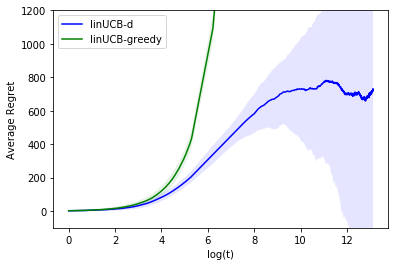

In [15]:
stride = 500;
head = 200;
index = np.zeros(N);
index[::stride] = 1;
index[:head] = 1;

X = np.log(range(1,N+1))[index==1];
plt.fill_between(X, 
                 (Reg_linUCBd[0]-2*Sigma_linUCBd[0])[index==1], 
                 (Reg_linUCBd[0]+2*Sigma_linUCBd[0])[index==1], 
                 alpha=0.1, edgecolor='none', facecolor='b');

plt.fill_between(X, 
                 (Reg_linUCBg[0]-2*Sigma_linUCBg[0])[index==1], 
                 (Reg_linUCBg[0]+2*Sigma_linUCBg[0])[index==1], 
                 alpha=0.1, edgecolor='none', facecolor='g');

plt.plot(X, Reg_linUCBd[0][index==1], 'b', label='linUCB-d');
plt.plot(X, Reg_linUCBg[0][index==1], 'g', label='linUCB-greedy')

plt.legend(loc='upper left');
plt.xlabel('log(t)');
plt.ylabel('Average Regret');
plt.ylim(-100, 1200);
plt.savefig('logn-AR-Rand.pdf');

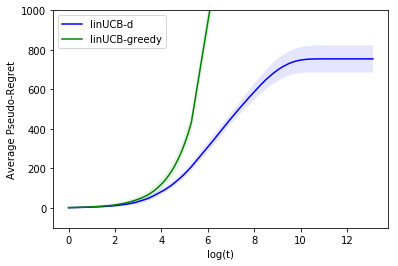

In [16]:
stride = 500;
head = 200;
index = np.zeros(N);
index[::stride] = 1;
index[:head] = 1;

X = np.log(range(1,N+1))[index==1];
plt.fill_between(X, 
                 (Reg_linUCBd[1]-2*Sigma_linUCBd[1])[index==1],
                 (Reg_linUCBd[1]+2*Sigma_linUCBd[1])[index==1], 
                 alpha=0.1, edgecolor='none', facecolor='b');

plt.fill_between(X, 
                 (Reg_linUCBg[1]-2*Sigma_linUCBg[1])[index==1],
                 (Reg_linUCBg[1]+2*Sigma_linUCBg[1])[index==1], 
                 alpha=0.1, edgecolor='none', facecolor='g');

plt.plot(X, Reg_linUCBd[1][index==1], 'b', label='linUCB-d');
plt.plot(X, Reg_linUCBg[1][index==1], 'g', label='linUCB-greedy');

plt.legend(loc='upper left');
plt.xlabel('log(t)');
plt.ylabel('Average Pseudo-Regret');
plt.ylim(-100, 1000);
plt.savefig('logn-PR-Rand.pdf');

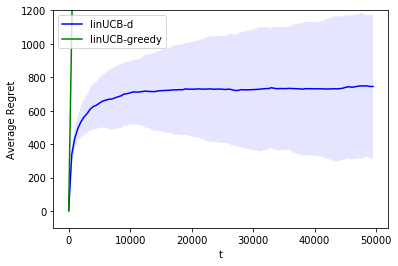

In [17]:
stride = 500;
head = (int)(N/10);
index = np.zeros(N);
index[:head:stride] = 1;

X = np.array(range(1,N+1))[index==1];
plt.fill_between(X, 
                 (Reg_linUCBd[0]-2*Sigma_linUCBd[0])[index==1],
                 (Reg_linUCBd[0]+2*Sigma_linUCBd[0])[index==1], 
                 alpha=0.1, edgecolor='none', facecolor='b');

plt.fill_between(X, 
                 (Reg_linUCBg[0]-2*Sigma_linUCBg[0])[index==1],
                 (Reg_linUCBg[0]+2*Sigma_linUCBg[0])[index==1], 
                 alpha=0.1, edgecolor='none', facecolor='g');

plt.plot(X, Reg_linUCBd[0][index==1], 'b', label='linUCB-d');
plt.plot(X, Reg_linUCBg[0][index==1], 'g', label='linUCB-greedy');

plt.legend(loc='upper left');
plt.xlabel('t');
plt.ylabel('Average Regret');
plt.ylim(-100, 1200);
plt.savefig('n-AR-Rand.pdf');

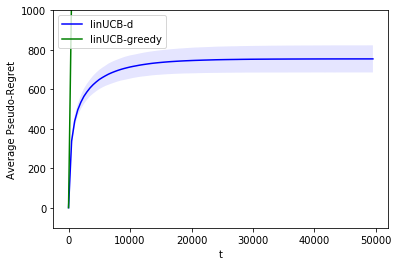

In [18]:
stride = 500;
head = (int)(N/10);
index = np.zeros(N);
index[:head:stride] = 1;

X = np.array(range(1,N+1))[index==1];
plt.fill_between(X, 
                 (Reg_linUCBd[1]-2*Sigma_linUCBd[1])[index==1], 
                 (Reg_linUCBd[1]+2*Sigma_linUCBd[1])[index==1], 
                 alpha=0.1, edgecolor='none', facecolor='b');

plt.fill_between(X, 
                 (Reg_linUCBg[1]-2*Sigma_linUCBg[1])[index==1], 
                 (Reg_linUCBg[1]+2*Sigma_linUCBg[1])[index==1], 
                 alpha=0.1, edgecolor='none', facecolor='g');

plt.plot(X, Reg_linUCBd[1][index==1], 'b', label='linUCB-d');
plt.plot(X, Reg_linUCBg[1][index==1], 'g', label='linUCB-greedy');

plt.legend(loc='upper left');
plt.xlabel('t');
plt.ylabel('Average Pseudo-Regret');
plt.ylim(-100, 1000);
plt.savefig('n-PR-Rand.pdf');

In [19]:
# CHECK REWARDS
print("Theta:");
print(theta);
print("Phi:");
print(Phi);

print("R:");
print(R);

print("R_max:");
print(R_max);

Theta:
[[7.96289417 2.34772044 0.88537361 5.50423825]
 [2.67889108 6.30751109 6.38115016 3.50995285]
 [7.11655236 0.64440651 5.74033444 3.99849763]
 [7.40980842 3.26387354 2.3933993  5.35849872]
 [4.51269048 4.63119049 0.14358909 7.62673465]]
Phi:
[[[0.17037818 0.57495996 0.0520054  0.79855354]
  [0.65679726 0.08857227 0.27944301 0.69475457]
  [0.54998187 0.48404869 0.33792732 0.59078078]
  ...
  [0.51707356 0.80577283 0.1411338  0.25188555]
  [0.5014599  0.0922855  0.7323176  0.45136713]
  [0.47952463 0.59192933 0.30488571 0.5715947 ]]

 [[0.6037221  0.48832772 0.55197705 0.30393586]
  [0.36853422 0.47613246 0.05960571 0.79619568]
  [0.33365437 0.07058524 0.0257778  0.93969569]
  ...
  [0.7117882  0.45340883 0.00503262 0.53642583]
  [0.30712543 0.14257166 0.00508802 0.94091519]
  [0.62512026 0.07134302 0.77490588 0.06046249]]

 [[0.47788832 0.59015353 0.33561431 0.55740883]
  [0.37406891 0.81551155 0.15289095 0.41429183]
  [0.67959058 0.22195412 0.12387022 0.68814909]
  ...
  [0.57810